# The quantum Fourier transform
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Check also [this notebook](https://github.com/rmlarose/QuIC-Seminar/tree/master/fall2019/08qft) on GitHub based on [this set](https://www.ryanlarose.com/uploads/1/1/5/8/115879647/shor2-qft.pdf) of Ryan LaRose lecture notes.


In [1]:
"""Imports and notebook setup."""

import matplotlib.pyplot as plt
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit


%matplotlib inline


The quantum Fourier transform is an integral part of many real quantum algorithms (phase estimation, Shor, etc...).
As we'll see, it is quite like a regular old discrete Fourier transform,  except that it acts on the *amplitudes of the wavefunction* of our set of qubits.

### Reminder: the *classical* Fourier transform
First, let's remind ourselves what a Fourier transform is and how we use computers to compute it.

Let $f(t)$ be a real-valued function of 'time'. 
The **Fourier transform** of $f(t)$ is defined to be

$$\mathcal{F}[f(t)] = \tilde{f}(\omega) = \int_{-\infty}^{\infty}f(t)e^{-2\pi i \omega t}dt$$

This operation is invertable: we can alyways take $\tilde{f}(t)$ and transform it back into $f(t)$ using the inverse Fourier transform

$$f(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty}\tilde{f}(\omega)e^{2\pi i \omega t}d\omega$$


The Fourier transform is an essential tool in the toolbox of scientists and engineers: it allows us to pick out frequency structure in a data set that is a function of time.
To actually compute a Fourier transform, we generally use the **discrete Fourier transform** (DFT): given a discrete $N$ dimensional input vector $f = (f_0, f_1, ..., f_{N-1})$, $\tilde{f}$ is the DFT of $f$, and the $k^{th}$ component of $\tilde{f}$ is given by:

$$\tilde{f_k} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\omega^{kj}f_j$$

where

$$\omega = e^{i2\pi/N}$$

This is more or less equivalent to breaking up the time integral into a Reimann sum.

We can see the utility of the DFT and its common implementation, the fast Fourier transform (FFT), by generating some test data and Fourier transforming it. 
Add frequency components to the data below: you can make some absolutely wild data that you'd never be able to disentangle by eye. 
However, the FFT can robustly pick out the frequency components you added in, even in the presence of substantial noise.

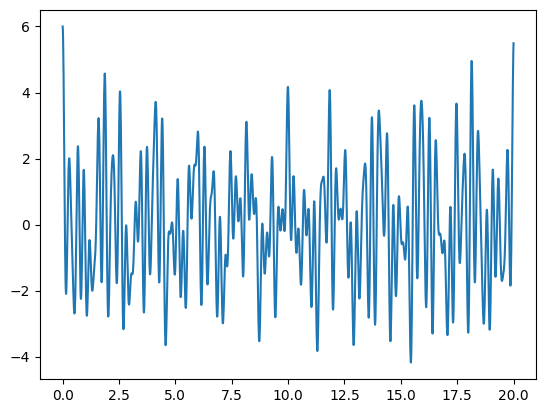

In [2]:
import scipy.fftpack as fft

#generate some complicated time data

l = 2000
x = np.linspace(0,20,l)
freqs = [0.5, 1.2, 4.3 ,2.7 ,3.2, np.pi] # add frequency components to this list to make arbitrarily complicated data
y = np.zeros(l)

for i in freqs:
    y = y + np.cos(x*i*2*np.pi) 

y = y #+ 1*np.random.rand(l) # uncomment for noise
    
plt.plot(x,y)

C:\Users\nicol\PycharmProjects\QuantumLab25\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\nicol\PycharmProjects\QuantumLab25\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 5.0)

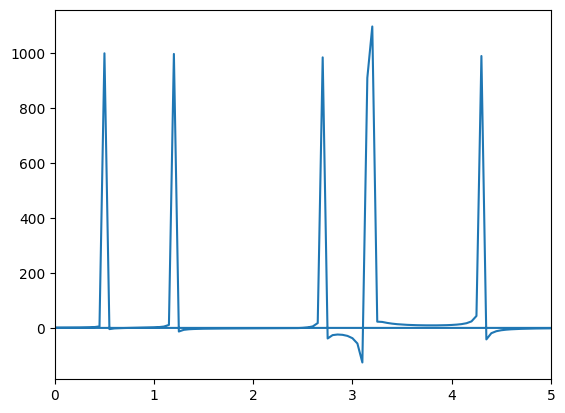

In [3]:
y_fft = fft.fft(y)

freq = fft.fftfreq(l,max(x)/l) # generate the corresponding frequency list

# the frequency components you added in will show up in the Fourier transform
fig, ax = plt.subplots()
ax.plot(freq,y_fft)
ax.set_xlim([0,5])

Let's consider again the sum: 

$$\tilde{f_k} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\omega^{kj}f_j$$

where

$$\omega = e^{i2\pi/N}$$

We recognize that the discrete Fourier transform is a linear map from $f$ to $\tilde{f}$: we can write our DFT as an $N\times N$ matrix acting on $f$: 
$$
\tilde{f} = \Omega f.
$$

By inspecting the sum element by element, we can construct $\Omega$ with relative ease:

$$ \Omega = \frac{1}{\sqrt{N}}\begin{pmatrix} 1 & 1 & 1 & 1 & 1 \\ 1 & \omega & \omega^2 & ... & \omega^{N-1} \\ 1 & \omega^2 & \omega^4 & ... & \omega^{2(N-1)}  \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ 1 & \omega^{N-1} & \omega^{2(N-1)} & ... & \omega^{(N-1)^2}  \end{pmatrix} $$

### Let's get quantum 

It can be shown that $\Omega$ is *unitary*, so we can apply $\Omega$ to an $N$ dimensional quantum state vector $\ket{\psi}$.
This is more or less exactly what the quantum Fourier transform (called QFT) is, although it is generally presented in a slightly different notation. 

Definition of the QFT: given $N = 2^n$, where $n$ is the number of qubits, let $\ket{k}$ and $\ket{j}$ be the computational basis vectors. The action of the QFT on a given computational basis vector $\ket{k}$ is defined as

$$ \ket{k} \xrightarrow{\text{QFT}} \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1}\omega^{jk}\ket{j}$$

where once again, $\omega = e^{2\pi i/2^n}$

When the QFT acts on an arbitrary statevector $\ket{\psi} = \sum_k \alpha_k\ket{k}$, the resulting statevector is

$$QFT\ket{\psi} = \sum_k \beta_k\ket{k}$$

where 

$$\beta_k = \frac{1}{\sqrt{2^n}} \sum_j \omega^{jk}\alpha_{k}$$

For $N=2$, the matrix $\Omega$ is:

$$ \Omega = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1  \\ 1 & \omega  \end{pmatrix} $$

$$ \Omega = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1  \\ 1 & -1  \end{pmatrix}, $$

Since $e^{2i\pi/2^n} = e^{i\pi/2} = -1$.

Thus, $QFT_2 = \dots $?






It's time to build the Quantum Fourier transform circuit!.

In [4]:
''' 
One qubit QFT
'''

q = QuantumRegister(1,name='q')   
qc = QuantumCircuit(q)


qc.draw()

q:

If you found $\Omega$ for $N = 4$, hopefully you found that

$$QFT_4 = \frac{1}{2}\begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & i & -1 & -i \\ 1 & -1 & 1 & -1 \\ 1 & -i & -1 & i \end{pmatrix} $$

At first, it doesn't look like there's a lot of structure to this matrix. However, if we *swap* columns 2 and 3, we end up with something that looks a lot more organized:

$$\tilde{QFT}_4 = \frac{1}{2}\begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & -1 & i & -i \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -i & i \end{pmatrix}  = \frac{1}{\sqrt{2}} \begin{pmatrix} H & SH \\ H & -SH\end{pmatrix}$$

Here, I've consolidated the top and bottom left $2\times 2$ blocks into Hadamards (easy to see), and consolidated the top and bottom right blocks into the phase gate multiplied by the Hadamard. As a reminder

$$ S = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix}$$

It turns out we can decompose $\tilde{QFT}_4$ as

$$ \tilde{QFT}_4 = (H \otimes I) (\ket{0}\bra{0}\otimes I + \ket{1}\bra{1}\otimes S ) (I \otimes H) $$

The term in the second parentheses is actually the *controlled S gate*, in fact, 

$$ \ket{0}\bra{0}\otimes I + \ket{1}\bra{1}\otimes S = \begin{pmatrix} 1&0&0&0 \\  0&1&0&0 \\  0&0&1&0 \\  0&0&0&i \end{pmatrix} = CS$$

We note that: 
$$
 CP(\theta) = \begin{pmatrix}
    1 & 0 & 0 & 0 \\ 
    0 & 1 & 0 & 0 \\ 
    0 & 0 & 1 & 0 \\ 
    0 & 0 & 0 & e^{i \theta}
    \end{pmatrix} 
$$

In particular, $CS = CP(\pi/2)$.

We can rewrite the $\tilde{QFT}_4$, like a 2 qubits circuit, as:
$$\tilde{QFT}_4 = H(0)\cdot CS(0,1) \cdot H(1) = H(1);CS(0,1);H(0)$$



In [5]:
'''
two qubit(swapped) fourier transform 
'''

q = QuantumRegister(2,name='q')
qc = QuantumCircuit(q)

qc.h(q[1])
qc.cp(np.pi/2, q[0] ,q[1])
qc.h(q[0])

qc.draw()


┌───┐
q_0: ──────■───────┤ H ├
     ┌───┐ │P(π/2) └───┘
q_1: ┤ H ├─■────────────
     └───┘

We're *super close* to having constructed the two qubit QFT: the last thing we need to do is remember that we swapped the $2^{nd}$ and $3^{rd}$ columns of $QFT_4$ to get $\tilde{QTF}_4$. It turns out that this is equivalent to *swapping the qubits*: we can undo this, and get the final circuit for $QFT_4$ by adding a SWAP operator at the end of our cicuit

In [6]:
''' The final two qubit QFT'''

q = QuantumRegister(2,name='q')
qc = QuantumCircuit(q)

qc.h(q[1])
qc.cp(np.pi/2, q[0] ,q[1])
qc.h(q[0])
qc.swap(q[0] ,q[1])

qc.draw()


┌───┐   
q_0: ──────■───────┤ H ├─X─
     ┌───┐ │P(π/2) └───┘ │ 
q_1: ┤ H ├─■─────────────X─
     └───┘

### The general QFT
That was a lot of work for a measly 2 qubit QFT. Fortunately, since we recognize $H$ as $QFT_2$, we see that 

$$\tilde{QFT}_4 =  \begin{pmatrix} QFT_2 & SQFT_2 \\ QFT_2 & -SQFT_2\end{pmatrix}$$

It turns out that there's a recursive relationship here. In general

$$\tilde{QFT}_N =  \begin{pmatrix} QFT_{N/2} & A_{N/2}QFT_{N/2} \\ QFT_{N/2} & -A_{N/2}QFT_{N/2}\end{pmatrix}$$
where $A$ is a series of controlled rotation gates, as we'll define below. 

<!-- We can decompose $\tilde{QFT}_N$ as

$$ \tilde{QFT}_N = (QFT_{N/2} \otimes I) (\ket{0}\bra{0}\otimes I + \ket{1}\bra{1}\otimes A_{N/2} ) (I \otimes QFT_{N/2}) $$ -->


The pattern of the general circuit will become clear when we look at the 4 qubit $QFT$ ($QFT_{16}$):


<img src="Image/4q_QFT.png" align="middle" >


Here, $R_n$ is a controlled rotation about the $Z$ axis by angle $2\pi/2^{(n+1)}$, i.e.

$$ CR_k = \begin{pmatrix}
    1 & 0 & 0 & 0 \\ 
    0 & 1 & 0 & 0 \\ 
    0 & 0 & 1 & 0 \\ 
    0 & 0 & 0 & e^{2\pi i/2^{k+1}}
    \end{pmatrix}
$$

Since $CR_k = CP(2 \pi/2^{k+1})$, we can use the gate `cp`.



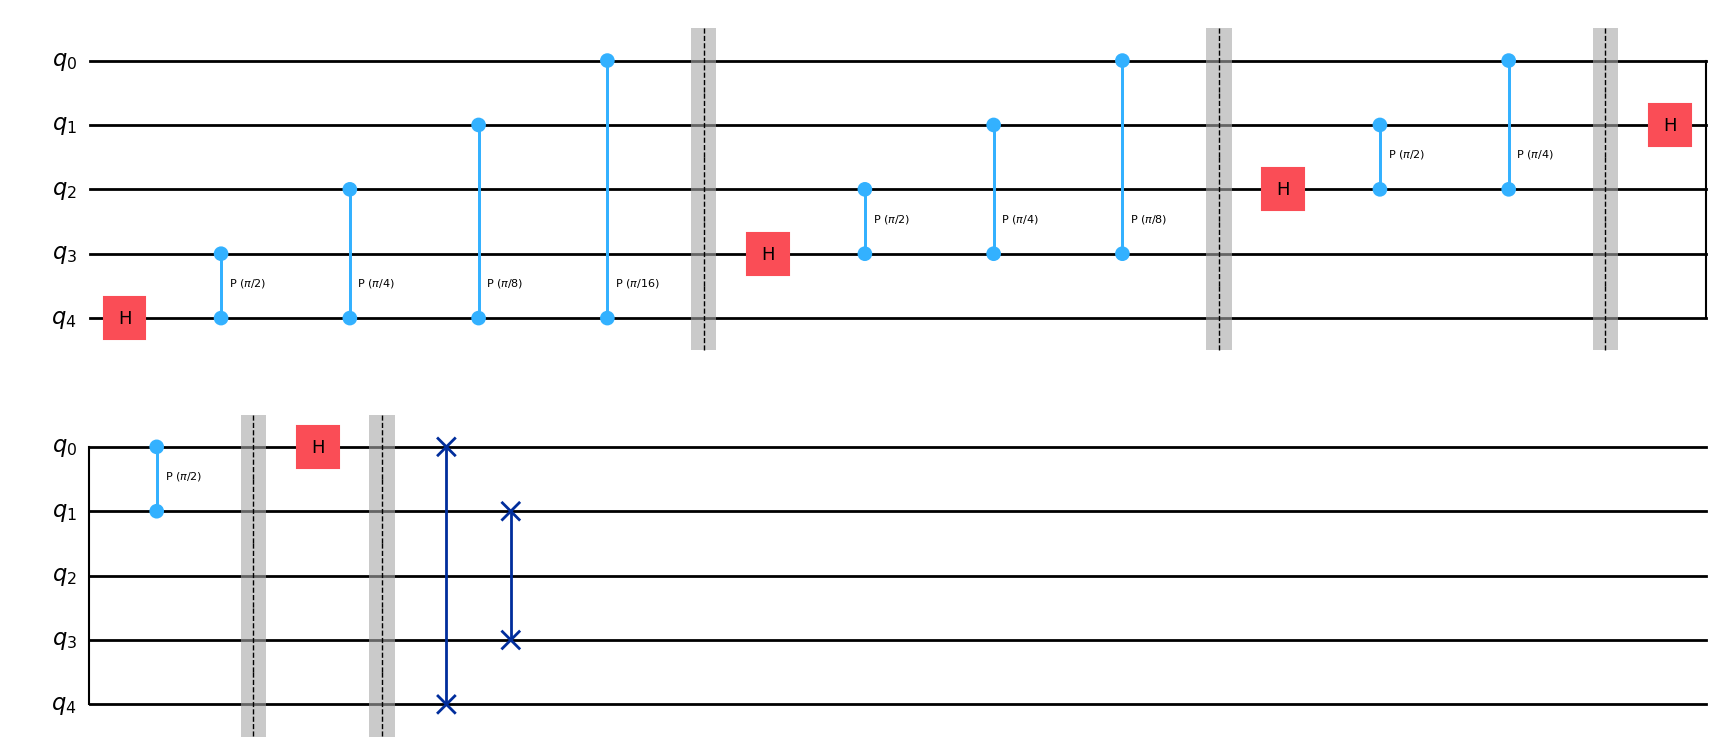

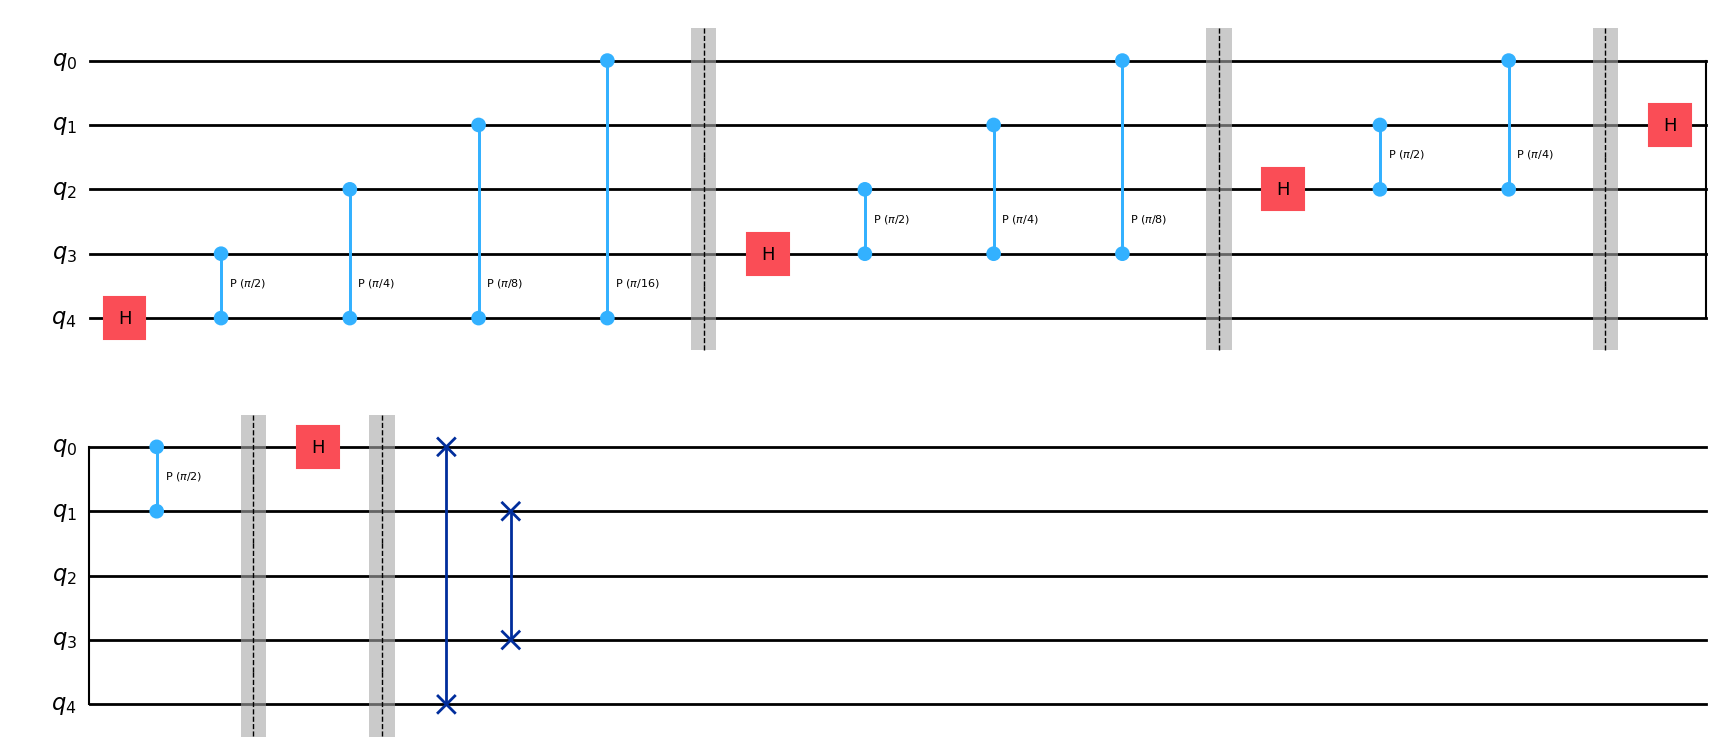

In [7]:

q = QuantumRegister(5,name='q')   
qc = QuantumCircuit(q)

qc.h(q[4])
qc.cp(np.pi/2, q[3] ,q[4])
qc.cp(np.pi/4, q[2] ,q[4])
qc.cp(np.pi/8, q[1] ,q[4])
qc.cp(np.pi/16, q[0] ,q[4])

qc.barrier()

qc.h(q[3])
qc.cp(np.pi/2, q[2] ,q[3])
qc.cp(np.pi/4, q[1] ,q[3])
qc.cp(np.pi/8, q[0] ,q[3])

qc.barrier()

qc.h(q[2])
qc.cp(np.pi/2, q[1] ,q[2])
qc.cp(np.pi/4, q[0] ,q[2])

qc.barrier()

qc.h(q[1])
qc.cp(np.pi/2, q[0] ,q[1])

qc.barrier()

qc.h(q[0])

qc.barrier()

qc.swap(q[0] ,q[4])
qc.swap(q[1] ,q[3])

qc.draw('mpl')


In a more compact way, we can define the QFT with a for loop:

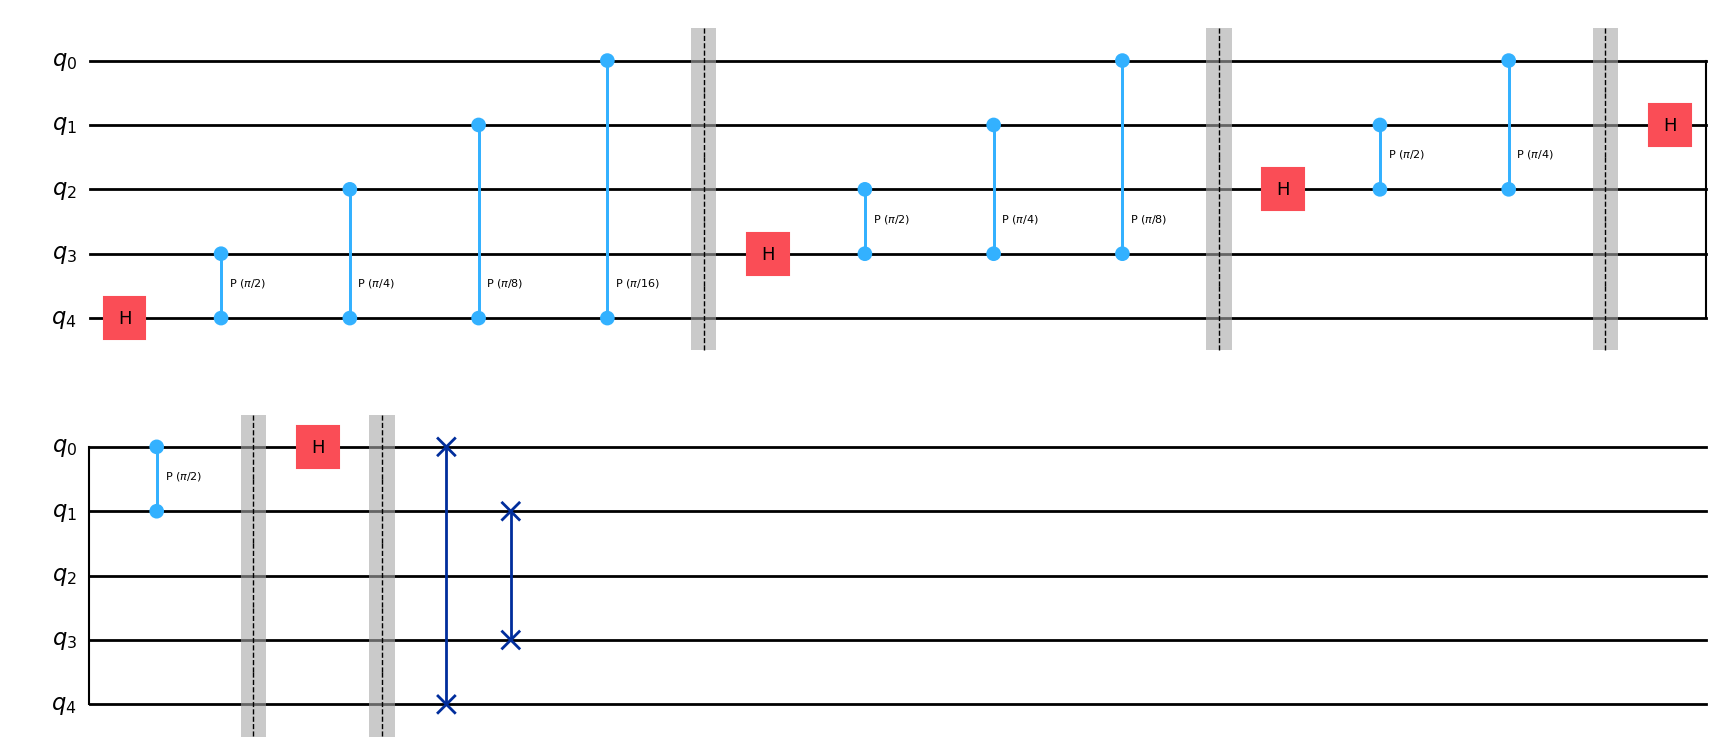

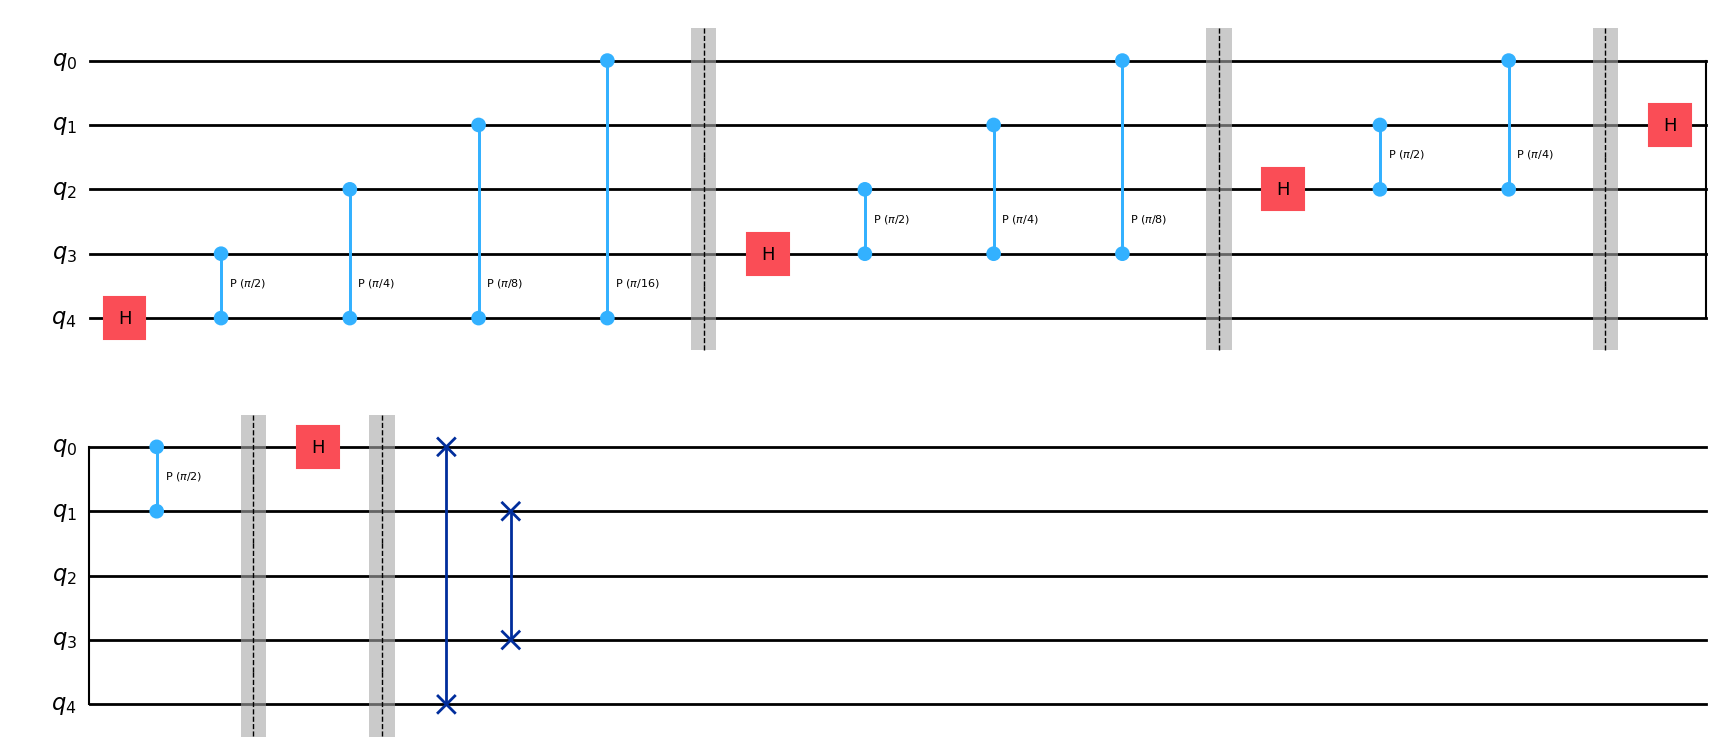

In [8]:
from numpy import pi

# number of qubits
n = 5
q = QuantumRegister(n, name='q')
qc = QuantumCircuit(q)


# QFT with n qubits
# First we apply hadamard and control phase gates
for j in range(n-1,-1,-1):
    qc.h(q[j])
    for k in range(j):
        qc.cp(pi/2**(k+1), q[j-1-k], q[j])
    qc.barrier()
# Now finish the QFT by reversing the order of the qubits
for j in range(n//2):
    qc.swap(q[j], q[n-j-1])
    
qc.draw('mpl')

Sometimes, you could find the QFT implemented in different ways.

Since it is easier to build a circuit, it's easy to find the implementation of the QFT with the phase gate in the reverse order.
Here an examples from [Qiskit official notebooks](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb)

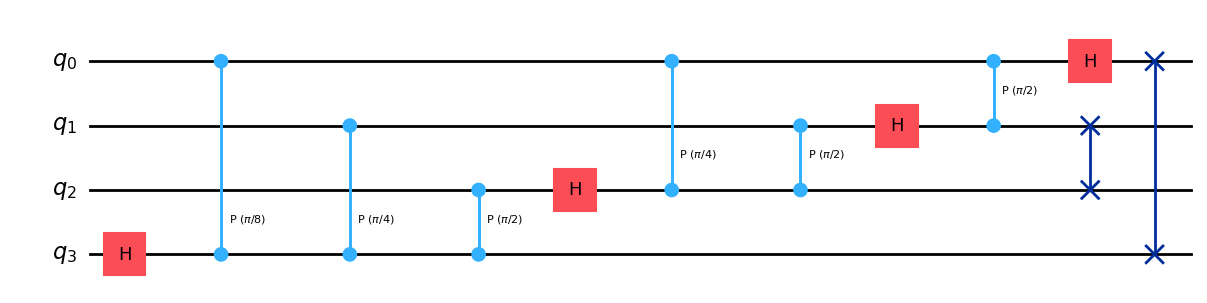

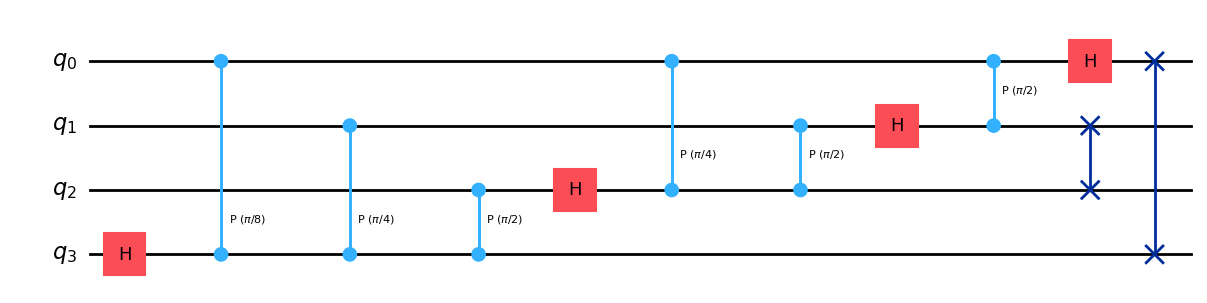

In [10]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
n = 4
qc = QuantumCircuit(n)
qft(qc,n)
qc.draw('mpl')

You may notice that, even for the 5 qubit circuit, some of these rotation gates are getting pretty small.
In fact, it's easy to see that as the circuit scales, the smallest rotation gets exponentially small in the circuit size. 
At some point it's not even worth trying to apply these small rotations: in the **approximate QFT**, we truncate the chain of rotations after some angle and forget about applying $R_k$ for some $k$ greater than some some number.
This approximation speeds up our QFT algorithm, however, that even without this approximation, the quantum fourier transform is exponentially faster than even the classical fast fourier transform.  

However, we need to bring up that **very important caveat** we mentioned all the way at the top: when you compute the QFT, you're Fourier transforming the *amplitudes of the n qubit wave function*. 

While you may get an exponential speedup over the FFT, state tomography (reconstructing the wavefunction from measurement) requires a number of measurements that *scales exponentially* with the size of the system, in other words, I need to run my circuit an *exponential* number of times.

The answer is that the applications of the quantum Fourier transform in quantum computing are more subtle than "Fourier transform this data set for me." 
The QFT acts as a computational "change of basis" (like the Hadamard, i.e. $QFT_2$, changes from the $Z$ basis to the $X$ basis and vice versa). 
This change of basis gets played out in action in perhaps a lot of famous quantum algorithms like Shor's factoring algorithm, Phase estimation algorithm or Grover's algorithm. 
